In [17]:
#!pip install yfinance pandas numpy matplotlib pandas-datareader statsmodels scikit-learn

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

Using 4 stocks from the S&P 500 Index including the index data. Additionally using Treasury and Crude Oil data from FRED.

In [2]:
start_date = '2000-01-01'
end_date = '2020-01-01'

# Collect historical data for S&P 500 Index and 4 Stocks
tickers = ['^GSPC', 'AEP', 'TSLA', 'BAC', 'AAPL']
data = yf.download(tickers, start=start_date, end=end_date)
data.index = data.index.tz_localize(None)

# Collect Federal Reserve Data in the same timeframe
series_ids = {
    '3MO': 'DGS3MO', # 3-Month Treasury Bill
    '1YR': 'DGS1', # 1-Year Treasury Constant Maturity Rate
    '5YR': 'DGS5', # 5-Year Treasury Constant Maturity Rate
    '10YR': 'DGS10', # 10- Year Treasury Constant Maturity Rate
    'DCOILWTICO': 'DCOILWTICO' # Crude Oil Prices
    }

def fetch_FED_Data(series_id, start, end):
    data = pdr.get_data_fred(series_id, start, end)
    if data is not None and not data.empty:
        # Ensure the index is of DateTime type
        data.index = pd.to_datetime(data.index)
        return data
    else:
        return pd.DataFrame()  # Return empty DataFrame if no data

fed_data = pd.DataFrame({name: fetch_FED_Data(series_id, start_date, end_date)[series_id]
                         for name, series_id in series_ids.items()})

fed_data.ffill(inplace=True)

[*********************100%***********************]  5 of 5 completed


###Historical Value of the Assets from 01/01/2010 to 01/01/2020

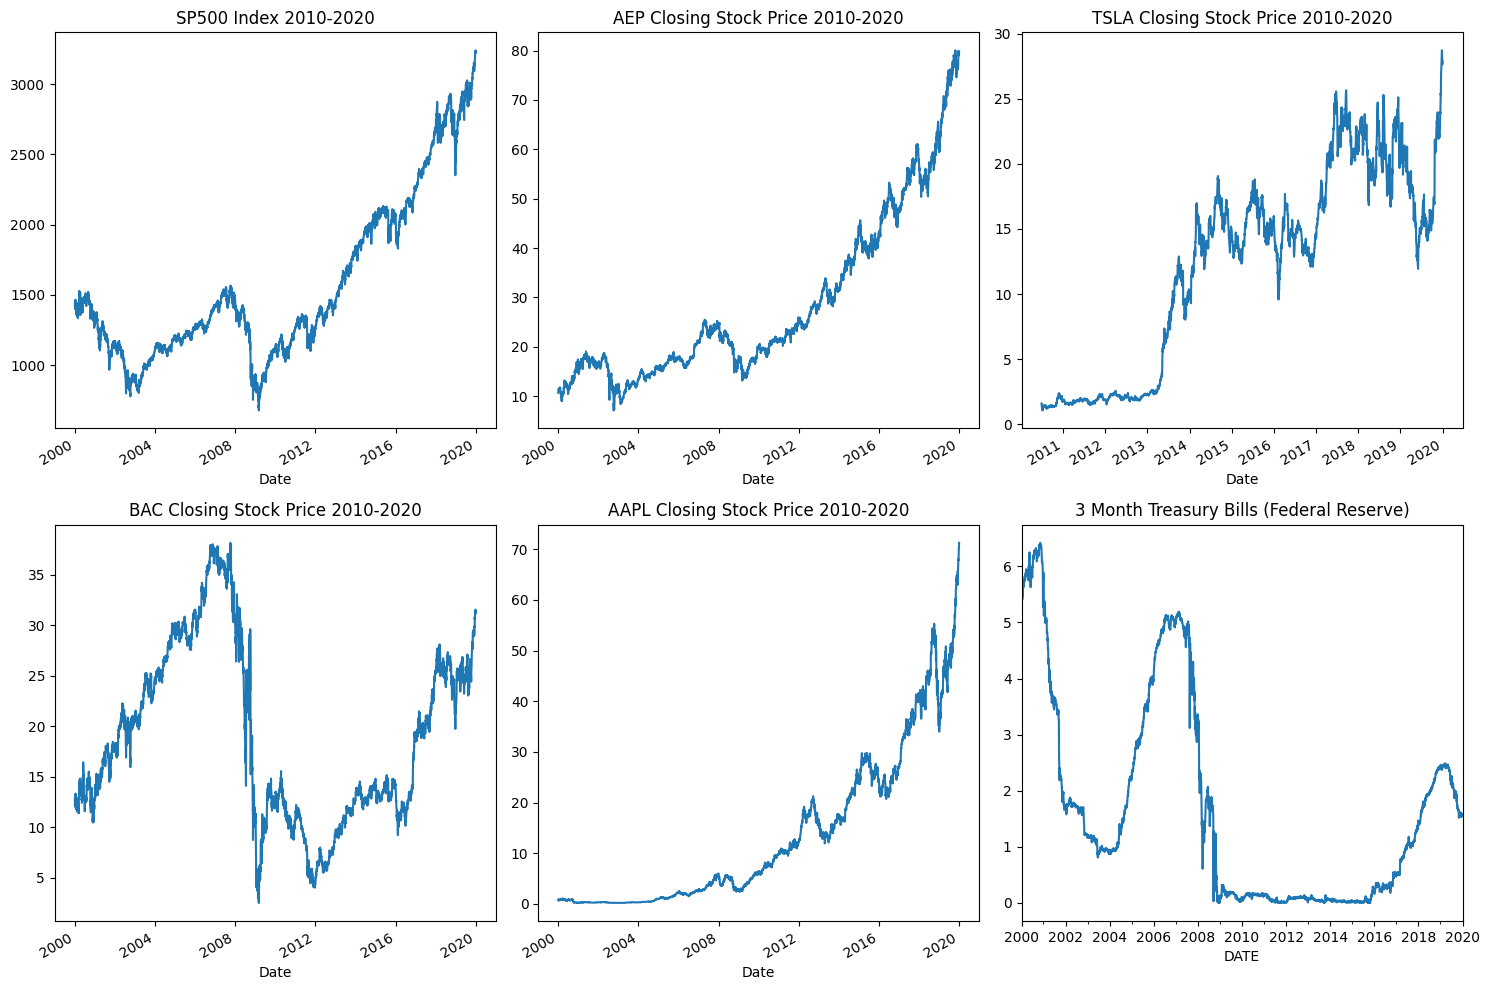

In [3]:
adj_close = data['Adj Close']

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = axes.flatten()

adj_close['^GSPC'].plot(ax=axes[0], title='SP500 Index 2010-2020')

for i, ticker in enumerate(tickers[1:]):
    adj_close[ticker].plot(ax=axes[i+1], title=f'{ticker} Closing Stock Price 2010-2020')

fed_data['3MO'].plot(ax=axes[5], title='3 Month Treasury Bills (Federal Reserve)')

plt.tight_layout()
plt.show()

In [18]:
# Merge the closing prices for the stock market data series
closing_prices = adj_close[['AEP','TSLA','BAC','AAPL', '^GSPC']].dropna()

closing_prices.columns = ['AEP', 'TSLA', 'BAC', 'AAPL', 'SP500']

merged_data = pd.merge(closing_prices, fed_data, left_index=True, right_index=True, how='left')

merged_data.ffill(inplace=True)

merged_data['log_returns_AEP'] = np.log(merged_data['AEP']).diff()
merged_data['log_returns_SP500'] = np.log(merged_data['SP500']).diff()
merged_data['log_returns_crude_oil'] = np.log(merged_data['DCOILWTICO']).diff()

#merged_data.replace([np.inf, -np.inf], np.nan, inplace=True)
#merged_data.dropna(inplace=True)
print(merged_data.head())

                  AEP      TSLA        BAC      AAPL        SP500   3MO   1YR  \
Date                                                                            
2010-06-29  18.906164  1.592667  11.641169  7.726047  1041.239990  0.15  0.31   
2010-06-30  18.680603  1.588667  11.481374  7.586102  1030.709961  0.18  0.32   
2010-07-01  18.634340  1.464000  11.201727  7.494114  1027.369995  0.17  0.32   
2010-07-02  18.732656  1.280000  11.057908  7.447670  1022.580017  0.17  0.31   
2010-07-06  19.235817  1.074000  11.233690  7.498641  1028.060059  0.17  0.32   

             5YR  10YR  DCOILWTICO  log_returns_AEP  log_returns_SP500  \
Date                                                                     
2010-06-29  1.78  2.97       75.93              NaN                NaN   
2010-06-30  1.79  2.97       75.59        -0.012002          -0.010164   
2010-07-01  1.80  2.96       72.95        -0.002480          -0.003246   
2010-07-02  1.82  3.00       72.06         0.005262          -

## Create the Capital Asset Pricing Model (CAPM)
###CAPM is representing by the following equation:
𝔼(𝑅ᵢ) = 𝑅ᵣ + 𝛽ᵢ(𝔼(𝑅ₘ) - 𝑅ᵢ),

Where:
*   𝔼(𝑅ᵢ) is the expected return of asset i
*   𝑅ᵣ is the expected risk-free return
*   𝛽ᵢ is the asset's beta (measurement of its sensitivity to the market)
*   𝔼(𝑅ₘ)is the expected return of the market

𝔼(𝑅ᵢ) - 𝑅ᵣ is the market risk premium, which is the extra return expected from holding the market portfolio over the risk-free assets. In regression form, CAPM is expressed as:

𝑅ᵢ - 𝑅ᵣ = α + 𝛽ᵢ(𝑅ₘ - 𝑅ᵢ) + ϵ,

Where:
*   α is the intercept
*   ϵ is white noise 𝑊𝑁(0, σ²)

In theory, if α ≠ 0 then we have either have an arbitrage opportunity or excess returns.

Here we will use the S&P 500 index to act as the market return and the 3 month treasury bill constant maturity rate as the risk-free rate.

In [5]:
# Daily Risk-Free Rate using 3 Month Treasury Bill
merged_data['log_returns_risk_free'] = np.log(1 + (merged_data['3MO'] / 100))

merged_data['excess_returns_AEP'] = merged_data['log_returns_AEP'] - merged_data['log_returns_risk_free']
merged_data['excess_returns_SP500'] = merged_data['log_returns_SP500'] - merged_data['log_returns_risk_free']
merged_data.replace([np.inf, -np.inf], np.nan, inplace=True)


regression_data = merged_data[['excess_returns_AEP', 'excess_returns_SP500']].dropna()

X = regression_data['excess_returns_SP500'].values.reshape(-1, 1)
y = regression_data['excess_returns_AEP'].values

model = LinearRegression().fit(X, y)
print(f"American Electric Power's (AEP) CAPM beta: {model.coef_[0]} | Intercept: {model.intercept_}")

American Electric Power's (AEP) CAPM beta: 0.6814755937349263 | Intercept: -0.0016147054711958186


### Extending the CAPM model with a crude oil factor

In [6]:
# Extend the CAPM model with an oil factor
extended_data = merged_data[['excess_returns_AEP', 'excess_returns_SP500', 'log_returns_crude_oil']].dropna()

X_extended = extended_data[['excess_returns_SP500', 'log_returns_crude_oil']]
y_extended = extended_data['excess_returns_AEP']

X_with_c = sm.add_constant(X_extended) # adds a column of ones for the intercept vector
extended_model = sm.OLS(y_extended, X_with_c).fit()
print(extended_model.summary())

                            OLS Regression Results                            
Dep. Variable:     excess_returns_AEP   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     905.2
Date:                Sat, 05 Oct 2024   Prob (F-statistic):          2.30e-293
Time:                        12:37:52   Log-Likelihood:                 7715.2
No. Observations:                2393   AIC:                        -1.542e+04
Df Residuals:                    2390   BIC:                        -1.541e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

## Regression Diagnostics

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


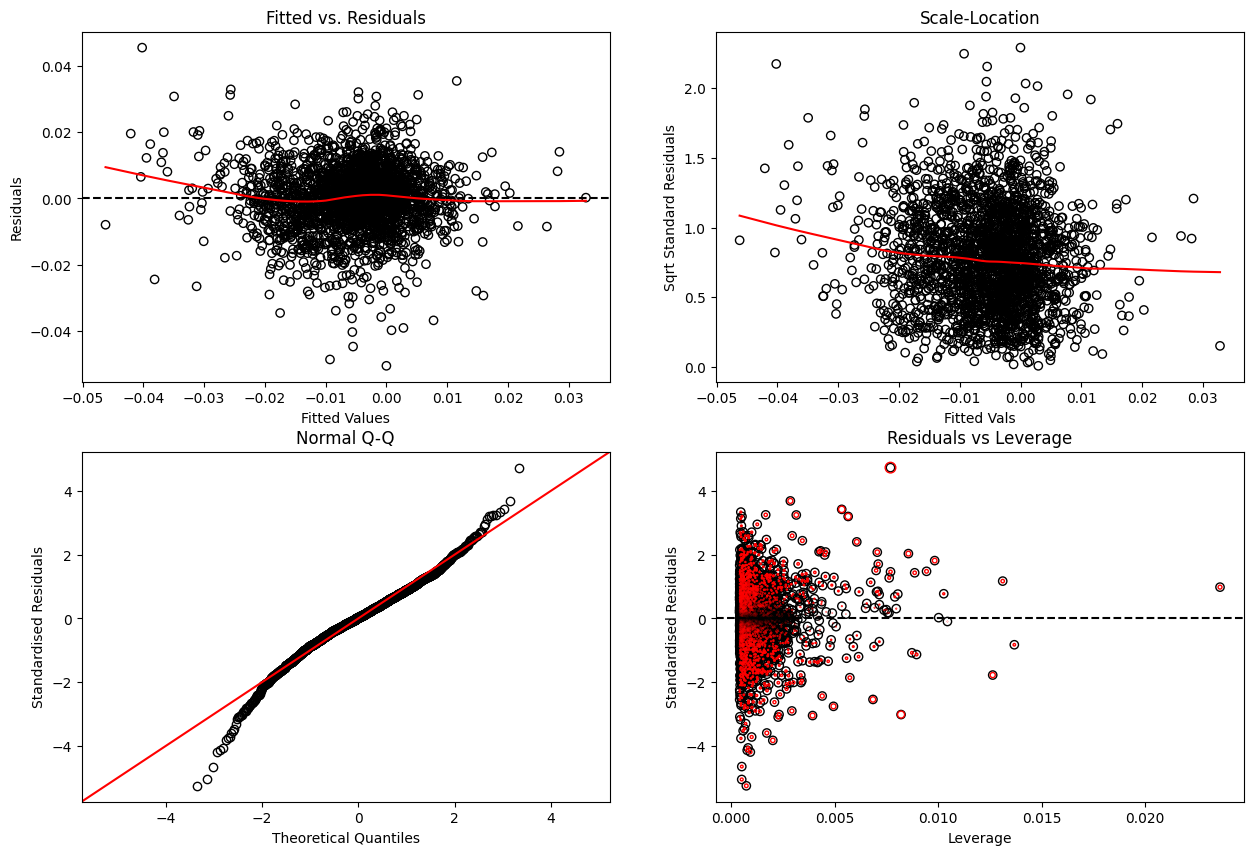

In [7]:
# Plot Regression Diagnostics
residuals = extended_model.resid
fitted_vals = extended_model.fittedvalues
standard_resid = residuals / np.std(residuals)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Fitted vs Residuals, LOWESS smoothing
axes[0, 0].scatter(fitted_vals, residuals, edgecolors='k', facecolors='none')
axes[0, 0].axhline(0, color='black', linestyle='--')
axes[0, 0].set_title("Fitted vs. Residuals")
axes[0, 0].set_xlabel("Fitted Values")
axes[0, 0].set_ylabel("Residuals")
lowess = sm.nonparametric.lowess(residuals, fitted_vals)
axes[0, 0].plot(lowess[:, 0], lowess[:, 1], color='red')


# Plot 2: Scale-Location
sqrt_standard_resid = np.sqrt(np.abs(standard_resid))
axes[0, 1].scatter(fitted_vals, sqrt_standard_resid, edgecolors='k', facecolors='none')

lowess = sm.nonparametric.lowess(sqrt_standard_resid, fitted_vals)
axes[0, 1].plot(lowess[:, 0], lowess[:, 1], color='red')
axes[0, 1].set_xlabel("Fitted Vals")
axes[0, 1].set_ylabel("Sqrt Standard Residuals")
axes[0, 1].set_title("Scale-Location")


#Plot 3: Normal Q-Q
sm.qqplot(standard_resid, ax=axes[1, 0], line='45', fmt='o', markerfacecolor='none', markeredgecolor='black', fit=True)
axes[1, 0].set_title("Normal Q-Q")
axes[1, 0].set_xlabel("Theoretical Quantiles")
axes[1, 0].set_ylabel("Standardised Residuals")


# Plot 4: Residuals vs Leverage
influence = extended_model.get_influence()
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]

axes[1, 1].scatter(leverage, standard_resid, edgecolors='k', facecolors='none')
axes[1, 1].axhline(0, color='black', linestyle='--')
axes[1, 1].set_title("Residuals vs Leverage")
axes[1, 1].set_xlabel("Leverage")
axes[1, 1].set_ylabel("Standardised Residuals")
axes[1, 1].scatter(leverage, standard_resid, s=1000*cooks_d, edgecolors='r', facecolors='none')
# sqrt(4/n) for cook's distance threshold
#n = len(standard_resid)
#plt.axhline(y=np.sqrt(4/n), color='red', linestyle='--', label="Cook's Distance Threshold")
#plt.axhline(y=-np.sqrt(4/n), color='red', linestyle='--')
#plt.legend()

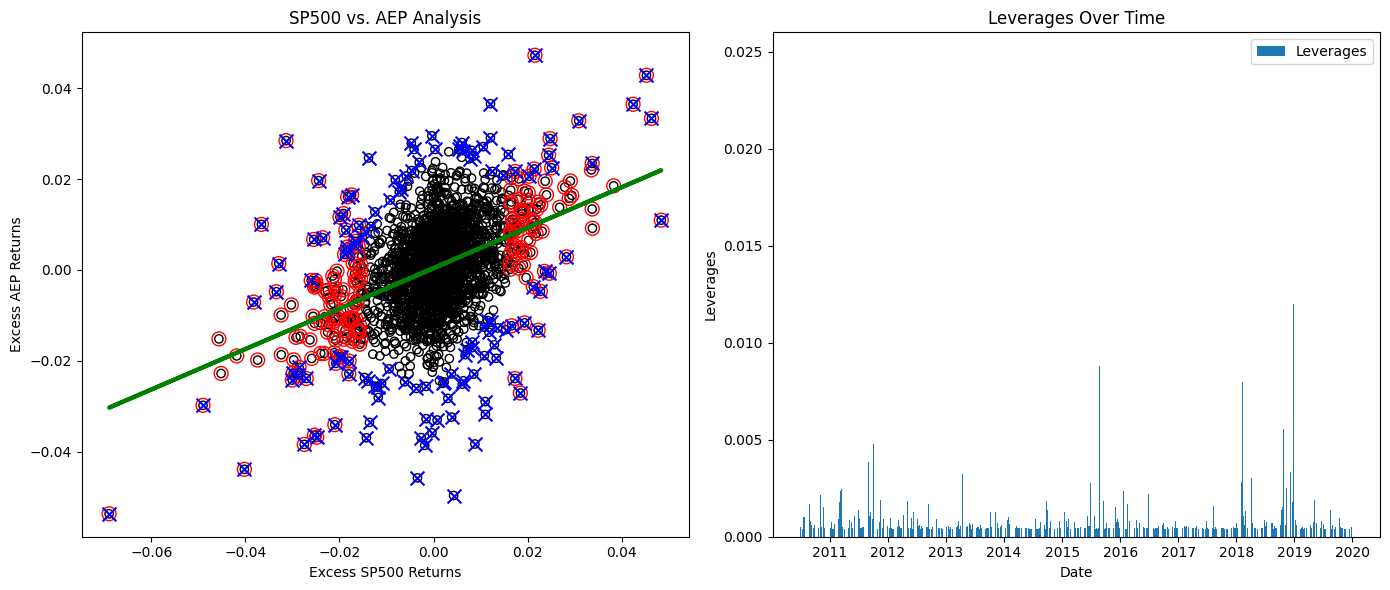

In [8]:
# Prep for the OLS
merged_data.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_data.dropna(inplace=True)
daily_returns_SP500 = merged_data[['log_returns_SP500']]
daily_returns_AEP = merged_data[['log_returns_AEP']]
X_single = merged_data[['log_returns_SP500']]
X_single = sm.add_constant(X_single)
y_single = merged_data['log_returns_AEP']

# Calculate OLS and the Cook's distance
single_model = sm.OLS(y_single, X_single).fit()
influence = single_model.get_influence()
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]

high_leverage_idx = np.where(leverage > 2*(np.mean(leverage)))[0]
high_cooks_idx = np.where(cooks_d > (4 / len(daily_returns_AEP)))[0]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 5: High Leverage
axes[0].scatter(daily_returns_SP500, daily_returns_AEP, color='black', label='Data', facecolors='none')

# OLS estimate
X_extended_2 = sm.add_constant(daily_returns_SP500)
axes[0].plot(daily_returns_SP500, single_model.predict(X_single), color='green', linewidth=3, label='OLS Fit')

# high leverage points
axes[0].scatter(daily_returns_SP500.iloc[high_leverage_idx], daily_returns_AEP.iloc[high_leverage_idx],
            color='red', s=100, label='High Leverage Points', marker='o', facecolors='none')

# high Cook's distance
axes[0].scatter(daily_returns_SP500.iloc[high_cooks_idx], daily_returns_AEP.iloc[high_cooks_idx],
            color='blue', s=100, label="High Crook's Distance", marker='x')

axes[0].set_title("SP500 vs. AEP Analysis")
axes[0].set_xlabel("Excess SP500 Returns")
axes[0].set_ylabel("Excess AEP Returns")

leverage_series = pd.Series(leverage, index=merged_data['log_returns_SP500'].index)
axes[1].bar(merged_data['log_returns_SP500'].index, leverage_series, label="Leverages")
axes[1].set_ylim(0, max(leverage_series) * 1.05)
axes[1].set_title("Leverages Over Time")
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Leverages')
axes[1].legend()

plt.tight_layout()
plt.show()

## Implementing Macro factors into the Model

Here we will compare a extended CAPM of Bank of America (BAC) with the extended AEP CAPM model, since CAPM relates a stock's return on a market portfolio. These returns are dependent on different factors such as commodities, interest rates, macro-economic factors.

In [9]:
# Simple BAC CAPM model
merged_data['log_returns_BAC'] = np.log(merged_data['BAC']).diff()
merged_data['excess_returns_BAC'] = merged_data['log_returns_BAC'] - merged_data['log_returns_risk_free']
merged_data.replace([np.inf, -np.inf], np.nan, inplace=True)

regression_data = merged_data[['excess_returns_BAC', 'excess_returns_SP500']].dropna()

X = regression_data['excess_returns_SP500'].values.reshape(-1, 1)
y = regression_data['excess_returns_BAC'].values

simple_model = LinearRegression().fit(X, y)
print(f"Bank of America's (BAC) CAPM beta: {simple_model.coef_[0]} | Intercept: {simple_model.intercept_}")

# Extend the CAPM model with an oil factor
extended_data = merged_data[['excess_returns_BAC', 'excess_returns_SP500', 'log_returns_crude_oil']].dropna()

X_extended = extended_data[['excess_returns_SP500', 'log_returns_crude_oil']]
y_extended = extended_data['excess_returns_BAC']

X_with_c = sm.add_constant(X_extended) # adds a column of ones for the intercept vector
extended_model = sm.OLS(y_extended, X_with_c).fit()
print(extended_model.summary())

Bank of America's (BAC) CAPM beta: 1.3157284736865622 | Intercept: 0.001667564687240779
                            OLS Regression Results                            
Dep. Variable:     excess_returns_BAC   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     1383.
Date:                Sat, 05 Oct 2024   Prob (F-statistic):               0.00
Time:                        12:38:31   Log-Likelihood:                 6673.8
No. Observations:                2392   AIC:                        -1.334e+04
Df Residuals:                    2389   BIC:                        -1.332e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

The R-Squared on the American Electric Power's (AEP) was lower than the Bank of America's R-Squared. This indicates that the market movements and oil returns have a stronger predictive power for BAC compared to AEP.

AEP had a negative oil coefficient, which makes sense, since higher oil prices would potentially squeeze profits if AEP cannot this cost onto the consumer. Additionally, utility firms are more defensive than other sectors and hence less sensitive to movements to the market.

Given that both models have a high F-score and a p-value close to 0 means that both these models are satistically significant.

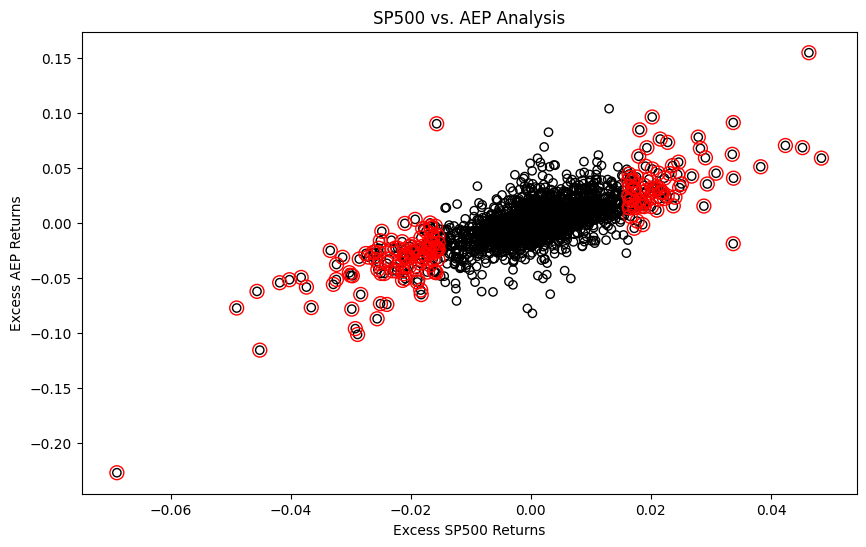

In [16]:
# Scatter plot of independent variables with high-leverage points
y_single = merged_data['log_returns_BAC']
X_single = sm.add_constant(daily_returns_SP500)
single_model = sm.OLS(y_single, X_single).fit()
daily_returns_BAC = merged_data[['log_returns_BAC']]

# Calculate OLS and the Cook's distance
influence = single_model.get_influence()
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]

high_leverage_idx = np.where(leverage > 2*(np.mean(leverage)))[0]
high_cooks_idx = np.where(cooks_d > (4 / len(daily_returns_BAC)))[0]

plt.figure(figsize=(10, 6))

# Plot 5: High Leverage
plt.scatter(daily_returns_SP500, daily_returns_BAC, color='black', label='Data', facecolors='none')

# OLS estimate
X_extended_2 = sm.add_constant(daily_returns_SP500)
plt.plot(daily_returns_SP500, single_model.predict(X_single), color='green', linewidth=3, label='OLS Fit')

# high leverage points
plt.scatter(daily_returns_SP500.iloc[high_leverage_idx], daily_returns_BAC.iloc[high_leverage_idx],
            color='red', s=100, label='High Leverage Points', marker='o', facecolors='none')

plt.title("SP500 vs. AEP Analysis")
plt.xlabel("Excess SP500 Returns")
plt.ylabel("Excess AEP Returns")
plt.show()